In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import colorcet as cc
from matplotlib.colors import ListedColormap
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

C:\Users\Nissim\AppData\Local\Temp\ipykernel_19128\1722922730.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
base_path = '../data/'


In [6]:
cluster_dat = gpd.read_file(base_path + 'clustering_data.geojson')

In [7]:
cluster_dat.head()

,geoid,namelsad,NAME,tot_pop_1940,tot_pop_1950,tot_pop_1960,tot_pop_1970,tot_pop_1980,tot_pop_1990,tot_pop_2000,...,age_10,age_middle,age_old,ta_cou_116,ta_count_c,ta_perc,ta_perc_fe,ui_exp,thrhld,geometry
0,3403160090,Pompton Lakes borough,"Pompton Lakes borough, Passaic County, New Jersey",3189.0,4654.0,9445.0,11397.0,10660.0,10539.0,10640.0,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-74.30288 41.01142, -74.30192 ..."
1,3402729550,Hanover township,"Hanover township, Morris County, New Jersey",2812.0,3756.0,9329.0,10700.0,11846.0,11538.0,12898.0,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-74.47451 40.81986, -74.47445 ..."
2,3402737110,Kinnelon borough,"Kinnelon borough, Morris County, New Jersey",745.0,1350.0,4431.0,7600.0,7770.0,8470.0,9365.0,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-74.43210 40.98401, -74.43154 ..."
3,3402756460,Parsippany-Troy Hills township,"Parsippany-Troy Hills township, Morris County,...",10976.0,15290.0,25557.0,55112.0,49868.0,48478.0,50649.0,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-74.53403 40.83312, -74.53401 ..."
4,3402775890,Victory Gardens borough,"Victory Gardens borough, Morris County, New Je...",982.0,876.0,1085.0,1027.0,1043.0,1314.0,1546.0,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-74.54931 40.87507, -74.54708 ..."


<Axes: >

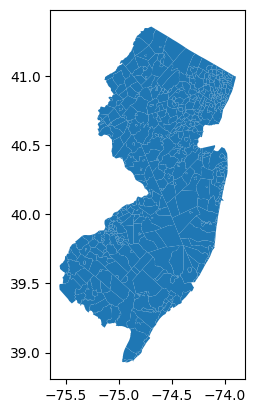

In [8]:
cluster_dat.plot()

In [9]:
# calculate the pct 70 year pop change from tot_pop_1950 and tot_pop_2020
cluster_dat['pct_70_year_pop_change'] = ((cluster_dat['tot_pop_2020'] - cluster_dat['tot_pop_1950']) / cluster_dat['tot_pop_1950']) * 100

In [11]:
# select the following columns: P200_I_PFS, FLD_PFS, pct_thirty_yr_pop_change, geometry
retreat_index_gdf = cluster_dat[['p200_i_pfs', 'fld_pfs', 'pct_70_year_pop_change', 'developed_high_intensity', 'geometry']]

In [15]:
retreat_index_gdf.head()

,p200_i_pfs,fld_pfs,pct_70_year_pop_change,developed_high_intensity,geometry
0,None,None,139.084658,0.044956,"MULTIPOLYGON (((-74.30288 41.01142, -74.30192 ..."
1,None,None,290.761448,0.058268,"MULTIPOLYGON (((-74.47451 40.81986, -74.47445 ..."
2,None,None,638.222222,0.004838,"MULTIPOLYGON (((-74.43210 40.98401, -74.43154 ..."
3,None,None,267.311969,0.053210,"MULTIPOLYGON (((-74.53403 40.83312, -74.53401 ..."
4,None,None,80.593607,0.065096,"MULTIPOLYGON (((-74.54931 40.87507, -74.54708 ..."


IndexError: index 0 is out of bounds for axis 0 with size 0

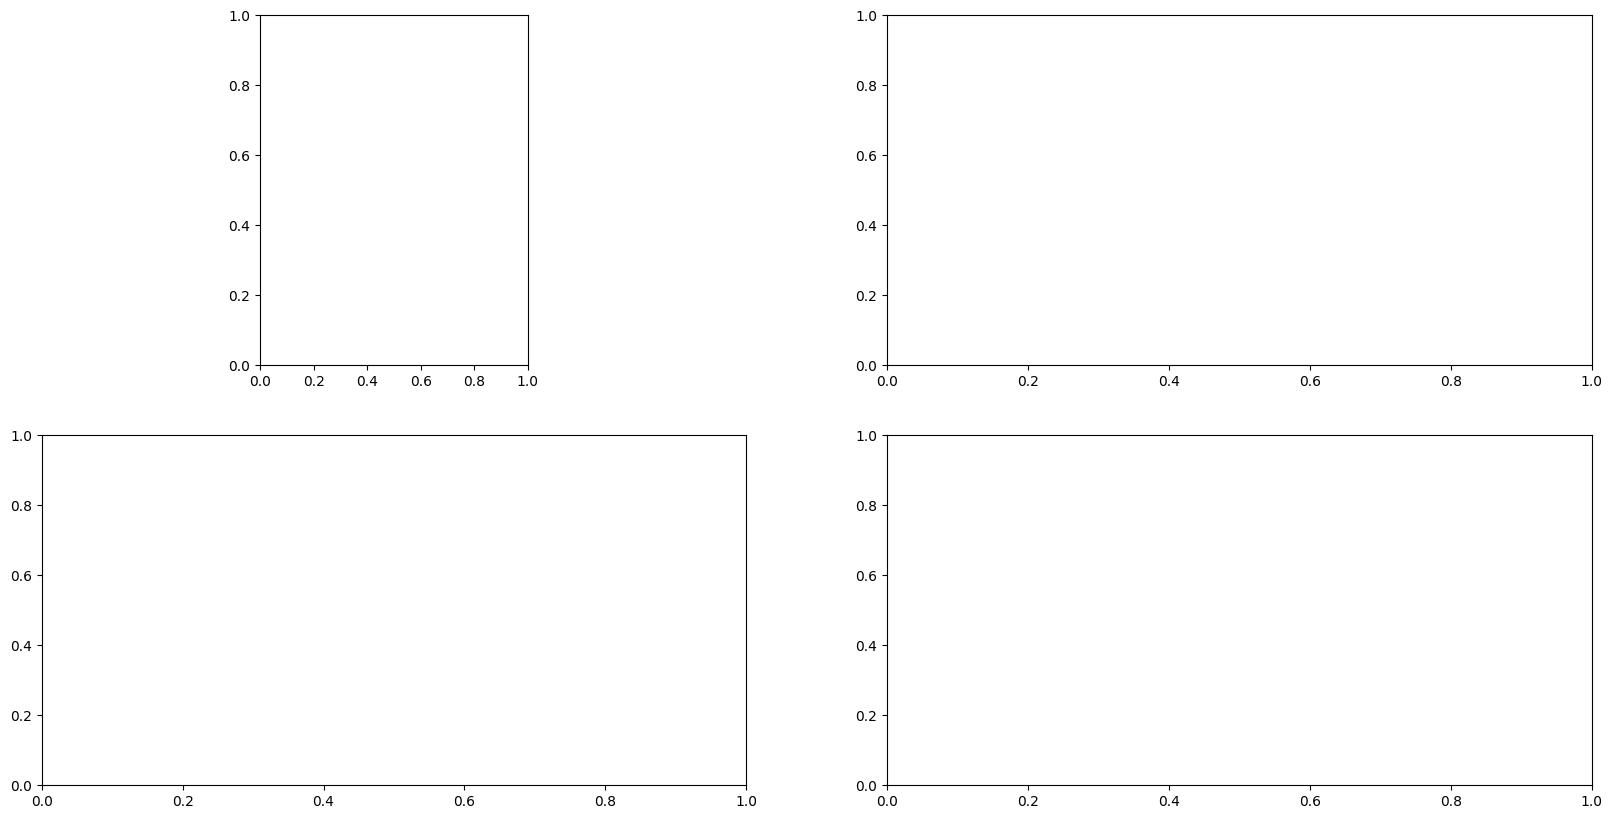

In [14]:
# plot maps of each of the numeric cols in the retreat_index_gdf
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
retreat_index_gdf.plot(column='p200_i_pfs', cmap='viridis', legend=True, ax=ax[0][0])
ax[0][0].set_title('Poverty')
retreat_index_gdf.plot(column='fld_pfs', cmap='viridis', legend=True, ax=ax[0][1])
ax[0][1].set_title('Flood Risk')
retreat_index_gdf.plot(column='pct_70_year_pop_change', cmap='viridis', legend=True, ax=ax[1][0])
ax[1][0].set_title('Pop Change')
retreat_index_gdf.plot(column='developed_high_intensity', cmap='viridis', legend=True, ax=ax[1][1])
ax[1][1].set_title('High Density (Industrial)')
plt.show()

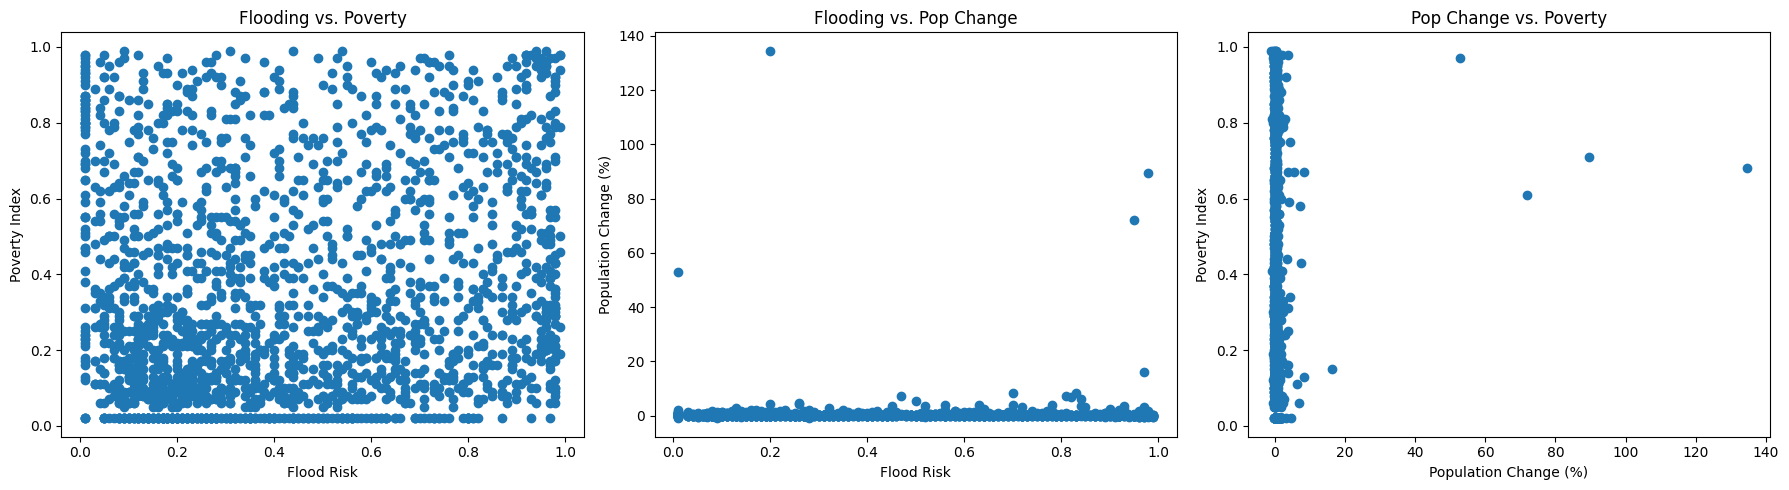

In [30]:
# Scatter plot for Flooding vs. Poverty
plt.figure(figsize=(18, 5))

# Flooding vs. Poverty
plt.subplot(1, 3, 1)
plt.scatter(retreat_index_gdf['FLD_PFS'], retreat_index_gdf['P200_I_PFS'])
plt.xlabel('Flood Risk')
plt.ylabel('Poverty Index')
plt.title('Flooding vs. Poverty')

# Flooding vs. Population Change
plt.subplot(1, 3, 2)
plt.scatter(retreat_index_gdf['FLD_PFS'], retreat_index_gdf['pct_thirty_yr_pop_change'])
plt.xlabel('Flood Risk')
plt.ylabel('Population Change (%)')
plt.title('Flooding vs. Pop Change')

# Population Change vs. Poverty
plt.subplot(1, 3, 3)
plt.scatter(retreat_index_gdf['pct_thirty_yr_pop_change'], retreat_index_gdf['P200_I_PFS'])
plt.xlabel('Population Change (%)')
plt.ylabel('Poverty Index')
plt.title('Pop Change vs. Poverty')

plt.tight_layout()
plt.show()

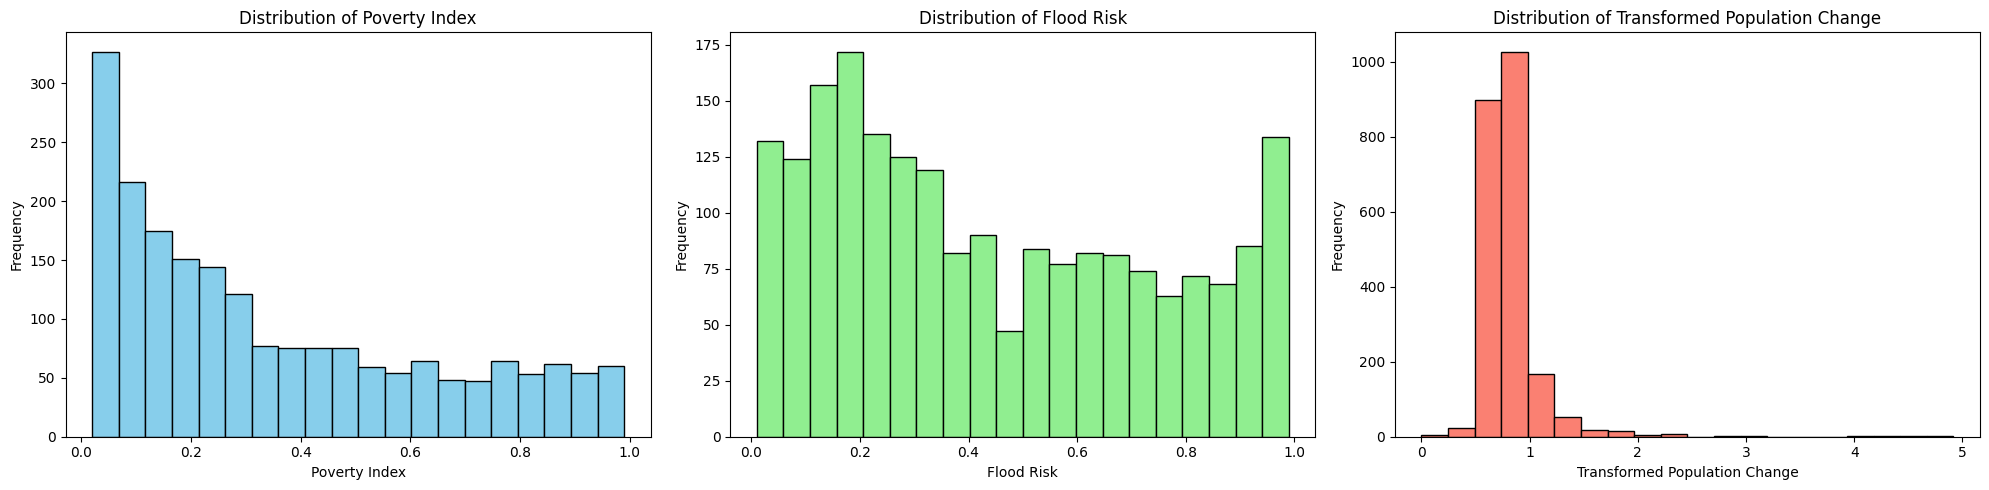

In [33]:
# Histogram for Poverty Index
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.hist(retreat_index_gdf['P200_I_PFS'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Poverty Index')
plt.ylabel('Frequency')
plt.title('Distribution of Poverty Index')

# Histogram for Flood Risk
plt.subplot(1, 3, 2)
plt.hist(retreat_index_gdf['FLD_PFS'], bins=20, color='lightgreen', edgecolor='black')
plt.xlabel('Flood Risk')
plt.ylabel('Frequency')
plt.title('Distribution of Flood Risk')

# Histogram for Population Change
# Assuming 'pct_thirty_yr_pop_change' is the column for population change
# Check if there are zero or negative values
if (retreat_index_gdf['pct_thirty_yr_pop_change'] <= 0).any():
    # Find the smallest value and add a constant to shift all data to be positive
    min_value = retreat_index_gdf['pct_thirty_yr_pop_change'].min()
    shift_constant = np.abs(min_value) + 1  # Ensure all values are positive
    transformed_pop_change = np.log(retreat_index_gdf['pct_thirty_yr_pop_change'] + shift_constant)
else:
    # Directly apply logarithmic transformation if all values are positive
    transformed_pop_change = np.log(retreat_index_gdf['pct_thirty_yr_pop_change'])

# Plotting the transformed distribution
plt.subplot(1, 3, 3)
plt.hist(transformed_pop_change, bins=20, color='salmon', edgecolor='black')
plt.xlabel('Transformed Population Change')
plt.ylabel('Frequency')
plt.title('Distribution of Transformed Population Change')

plt.tight_layout()
plt.show()

In [34]:
# Step 1: Log-transform the population change variable
min_value = retreat_index_gdf['pct_thirty_yr_pop_change'].min()
shift_constant = np.abs(min_value) + 1
retreat_index_gdf['log_pct_thirty_yr_pop_change'] = np.log(retreat_index_gdf['pct_thirty_yr_pop_change'] + shift_constant)

# Step 2: Z-score normalize the variables
scaler = StandardScaler()
variables_to_normalize = ['P200_I_PFS', 'FLD_PFS', 'log_pct_thirty_yr_pop_change']
# Drop NA values from the dataframe to avoid errors in scaling and clustering
cleaned_gdf = retreat_index_gdf.dropna(subset=variables_to_normalize)
normalized_data = scaler.fit_transform(cleaned_gdf[variables_to_normalize])
normalized_df = pd.DataFrame(normalized_data, columns=variables_to_normalize, index=cleaned_gdf.index)

c:\Users\Nissim\Documents\GitHub\mach-superstudio\.venv\lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


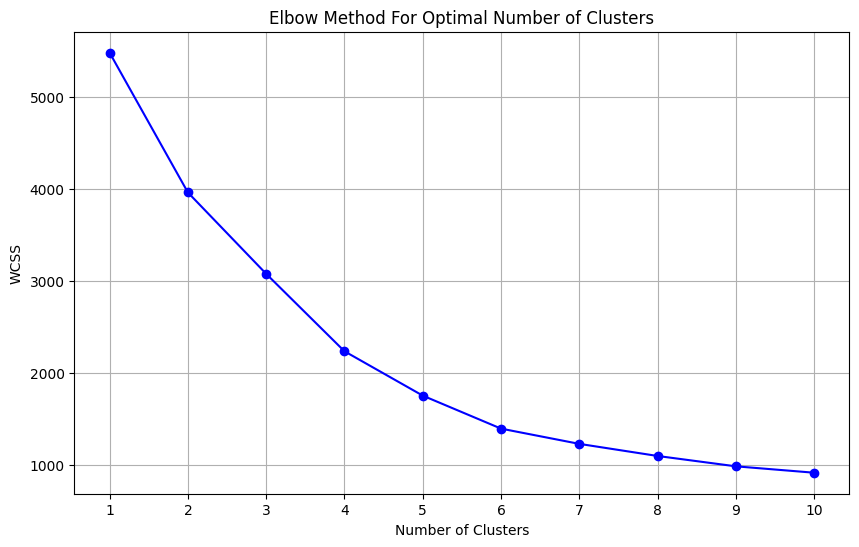

In [35]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Compute WCSS for different numbers of clusters
wcss = []  # List to store WCSS values
cluster_range = range(1, 11)  # Adjust the range as needed

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(normalized_df)  # Assuming 'normalized_df' is your pre-processed data
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS

# Step 2: Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wcss, marker='o', linestyle='-', color='blue')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

In [36]:
# Step 3: Cluster the normalized and cleaned data
kmeans = KMeans(n_clusters=7, random_state=42)  # Adjust the number of clusters as needed
clusters = kmeans.fit_predict(normalized_df)

In [37]:
cleaned_gdf['cluster'] = clusters  # Add cluster labels to the cleaned GeoDataFrame

c:\Users\Nissim\Documents\GitHub\mach-superstudio\.venv\lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [38]:
# Step 4: Map the clusters
# Ensure the GeoDataFrame for plotting includes the cluster information
retreat_index_gdf = retreat_index_gdf.merge(cleaned_gdf[['cluster']], left_index=True, right_index=True, how='left')

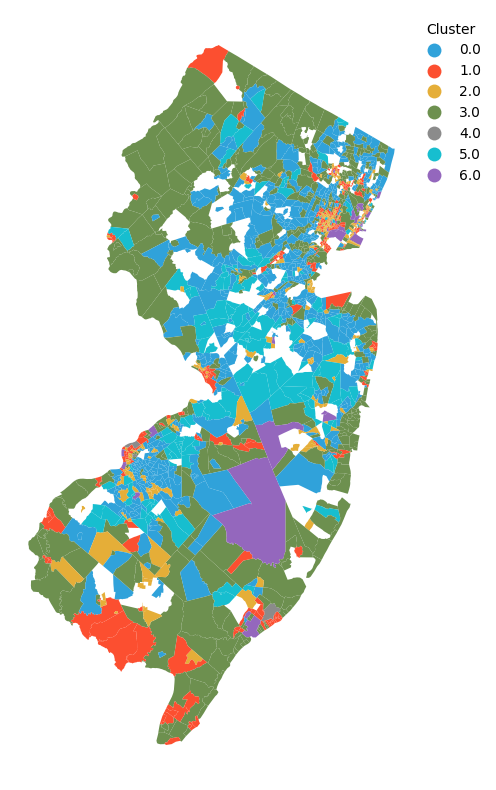

In [39]:
# Select a colorcet palette and create a ListedColormap
colors = cc.glasbey_hv[:7]  # For 7 clusters
cmap = ListedColormap(colors)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))  # Increase figure size
retreat_index_gdf.plot(column='cluster', cmap=cmap, legend=True, ax=ax, categorical=True)

# Adjusting the legend to be outside
legend = ax.get_legend()
if legend:
    legend.set_bbox_to_anchor((1.2, 1))  # Move the legend further right
    legend.set_title('Cluster')
    legend.set_frame_on(False)  # Remove the frame of the legend

# Remove the frame, ticks, and labels
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the layout to leave space for the legend
plt.show()


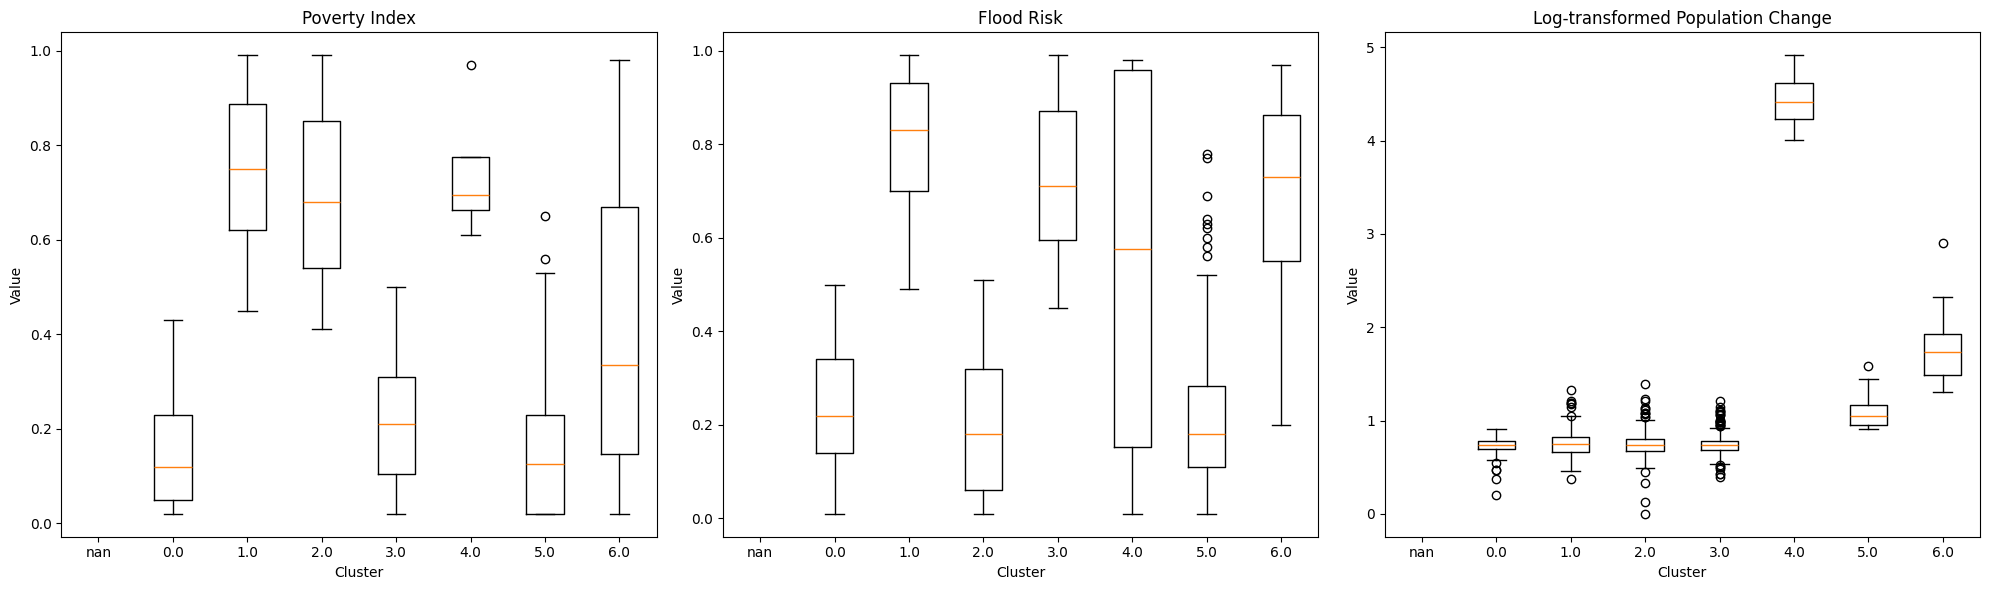

In [40]:
# Variables to plot
variables = ['P200_I_PFS', 'FLD_PFS', 'log_pct_thirty_yr_pop_change']
titles = ['Poverty Index', 'Flood Risk', 'Log-transformed Population Change']

# Creating box plots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, var, title in zip(axes, variables, titles):
    # Prepare data for plotting: extract values for each cluster
    data_to_plot = [retreat_index_gdf[retreat_index_gdf['cluster'] == cluster][var] for cluster in sorted(retreat_index_gdf['cluster'].unique())]
    
    # Create box plot
    ax.boxplot(data_to_plot)
    
    # Setting titles and labels
    ax.set_title(title)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Value')
    ax.set_xticklabels(sorted(retreat_index_gdf['cluster'].unique()))

plt.tight_layout()
plt.show()


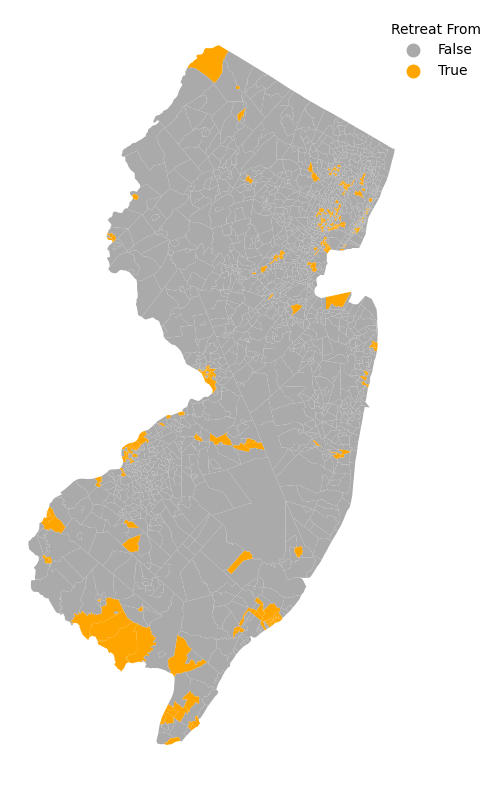

In [48]:
# Create a new column 'highlight' that is True for clusters 2 and 3, and False otherwise
retreat_index_gdf['highlight'] = retreat_index_gdf['cluster'].isin([1, 4])

# Create a color map for the highlight: use bright colors for True (clusters 2 and 3) and a dull color for False
highlight_cmap = ListedColormap(['#aaaaaa', '#ff0000', 'orange'])

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))  # Increase figure size
retreat_index_gdf.plot(column='highlight', cmap=highlight_cmap, legend=True, ax=ax, categorical=True)

# Adjusting the legend to be outside
legend = ax.get_legend()
if legend:
    legend.set_bbox_to_anchor((1.2, 1))  # Move the legend further right
    legend.set_title('Retreat From')
    legend.set_frame_on(False)  # Remove the frame of the legend

# Remove the frame, ticks, and labels
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the layout to leave space for the legend
plt.show()

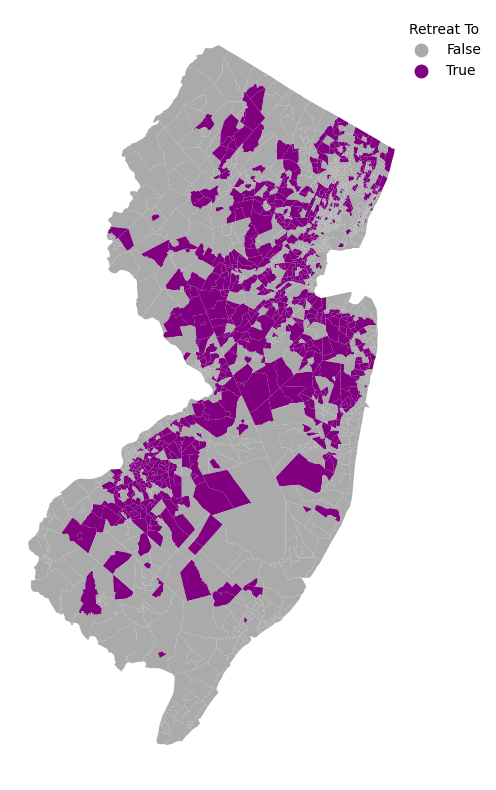

In [49]:
# Create a new column 'highlight' that is True for clusters 2 and 3, and False otherwise
retreat_index_gdf['retreat_to'] = retreat_index_gdf['cluster'].isin([0, 5])

# Create a color map for the highlight: use bright colors for True (clusters 2 and 3) and a dull color for False
highlight_cmap = ListedColormap(['#aaaaaa', '#ff0000', 'purple'])

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))  # Increase figure size
retreat_index_gdf.plot(column='retreat_to', cmap=highlight_cmap, legend=True, ax=ax, categorical=True)

# Adjusting the legend to be outside
legend = ax.get_legend()
if legend:
    legend.set_bbox_to_anchor((1.2, 1))  # Move the legend further right
    legend.set_title('Retreat To')
    legend.set_frame_on(False)  # Remove the frame of the legend

# Remove the frame, ticks, and labels
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the layout to leave space for the legend
plt.show()